<img style="float: right;" src="hyperstream.svg">

# HyperStream Tutorial 3: Stream composition

We will be ussing the tool created in the previous tutorial and we will compose the output of the stream with a new one.

In [1]:
%load_ext watermark

import sys
from datetime import datetime

sys.path.append("../") # Add parent dir in the Path

from hyperstream import HyperStream
from hyperstream import TimeInterval
from hyperstream.utils import UTC

from graphviz import Digraph

from utils import plot_high_chart

%watermark -v -m -p hyperstream,graphviz -g

CPython 2.7.6
IPython 5.3.0

hyperstream 0.3.0-beta
graphviz 0.7.1

compiler   : GCC 4.8.4
system     : Linux
release    : 3.19.0-80-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : 01e9ff80d8882214b54405871a5655ad567288fb


In [2]:
hs = HyperStream(loglevel=20)
print hs

reader_tool = hs.plugins.example.tools.csv_reader('data/sea_ice.csv')
sea_ice_stream = hs.channel_manager.memory.get_or_create_stream("sea_ice")


ti = TimeInterval(datetime(1990, 1, 1).replace(tzinfo=UTC), datetime(2012, 1, 1).replace(tzinfo=UTC))

reader_tool.execute(sources=[], sink=sea_ice_stream, interval=ti)
for key, value in sea_ice_stream.window().items()[:10]:
    print '[%s]: %s' % (key, value)

HyperStream version 0.3.0-beta, connected to mongodb://localhost:27017/hyperstream
[1990-02-01 00:00:00+00:00]: [13.33, 2.15]
[1990-03-01 00:00:00+00:00]: [13.44, 2.71]
[1990-04-01 00:00:00+00:00]: [12.16, 5.1]
[1990-05-01 00:00:00+00:00]: [10.84, 7.37]
[1990-06-01 00:00:00+00:00]: [9.12, 10.26]
[1990-07-01 00:00:00+00:00]: [6.44, 12.17]
[1990-08-01 00:00:00+00:00]: [4.92, 13.95]
[1990-09-01 00:00:00+00:00]: [4.5, 14.3]
[1990-10-01 00:00:00+00:00]: [6.67, 13.71]
[1990-11-01 00:00:00+00:00]: [9.58, 11.24]


## Stream composition

We can compose a chain of streams using different tools to get a new stream. As an example, we can use the tool **read_csv** to generate a stream from a csv file. Then, we can apply the tool **list_sum**, that sums all the values of each instance of a stream, and outputs a new stream. Finally, we can define the new stream to store the output in **memory** or in a  **MongoDB** database (like in the following example).

|~stream||tool||stream||tool||stream|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| csv_file | $\rightarrow$ | reader_tool | $\rightarrow$ | sea_ice_stream | $\rightarrow$ | list_sum_tool | $\rightarrow$ | sea_ice_sum_stream |
|filesystem||memory||memory||memory||MongoDB|

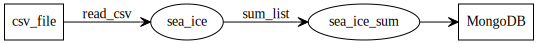

In [3]:
ps = Digraph(name='Stream', node_attr={'shape': 'oval'})

ps.node('csv_file', shape='rectangle')
ps.node('sea_ice')
ps.node('sea_ice_sum')
ps.node('MongoDB', shape='rectangle')
ps.edge('csv_file', 'sea_ice', label='read_csv')
ps.edge('sea_ice', 'sea_ice_sum', label='sum_list')
ps.edge('sea_ice_sum', 'MongoDB')

ps.graph_attr['rankdir'] = 'LR'
ps.edge_attr.update(arrowhead='vee', arrowsize='1')

ps

In [7]:
list_sum_tool = hs.tools.list_sum()

sea_ice_sums_stream = hs.channel_manager.mongo.get_or_create_stream('sea_ice_sums')
list_sum_tool.execute(sources=[sea_ice_stream], sink=sea_ice_sums_stream, interval=ti)

for key, value in sea_ice_sums_stream.window().items()[:10]:
    print '[%s]: %s' % (key, value)

[1990-02-01 00:00:00+00:00]: 15.48
[1990-03-01 00:00:00+00:00]: 16.15
[1990-04-01 00:00:00+00:00]: 17.26
[1990-05-01 00:00:00+00:00]: 18.21
[1990-06-01 00:00:00+00:00]: 19.38
[1990-07-01 00:00:00+00:00]: 18.61
[1990-08-01 00:00:00+00:00]: 18.87
[1990-09-01 00:00:00+00:00]: 18.8
[1990-10-01 00:00:00+00:00]: 20.38
[1990-11-01 00:00:00+00:00]: 20.82


In [8]:
my_time, my_data = zip(*[(key.__str__(), value) for key, value in sea_ice_sums_stream.window().items()])

plot_high_chart(my_time, my_data, type="high_stock", 
                title='Sum of sea levels in the Artic and the Antartica', yax='meters')